##Pancreas Cancer


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi
!nvcc --version

/opt/bin/nvidia-smi  /usr/bin/nvidia-smi
Thu Feb 18 02:50:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

##Import Dependencies

In [3]:
%%capture
!pip install pydicom
!pip install pillow
!pip install torchio
!pip install torch-lr-finder
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from collections import OrderedDict
import random
from random import shuffle

import pydicom as dicomio
import nibabel as nib

import torch
import torch.utils.data
import torchvision
from torch.utils.data import Dataset
from torchsummary import summary
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch_lr_finder import LRFinder
import albumentations as A
import torchio as tio

In [4]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [5]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(26)

In [6]:
!mv /*.py /content/

mv: cannot stat '/*.py': No such file or directory


In [7]:
from loss import TverskyLoss
from net import UNet_2D, UNet_3D
from volume_patch_composer import volume_composer, patch_creator
from dataset import Pancreas_2D_dataset, Pancreas_3D_dataset
from metrics import performance_metrics
from train import train_2D, train_3D

##Set the Hyperparameters

In [8]:
#set parameters
#Define type of segmentation (2D or 3D): bool
unet_2d = False

#volume resize parameters (d1,d2,d3) are (height, width,depth)
d1 = torch.linspace(-1, 1, 256)
d2 = torch.linspace(-1, 1, 256)
d3 = torch.linspace(-1,1, 128)
#patch parameters for volumetric segmentation
if unet_2d == False:
  #kernel size
  kc, kh, kw = 32,64,64
  #stride  
  dc, dh, dw = 32,64,64

batch_size = 16
num_workers = 0
#Define type of optimizer as either 'Adam' or 'SGD'
optimizer_type = 'Adam'
n_epochs = 2    #100
#If you are willing to find the maximum learning rate using One Cycle learning 
#rate policy set lr_find to True
lr_find = False
#If you wish to use the pretrained model set to True
inference_only = False


##Import Datasets

In [9]:
!mkdir data/
!mkdir data3D

In [10]:
%%capture
!cp /content/drive/MyDrive/Pancreas-CT.zip /content/
!unzip   Pancreas-CT.zip



In [11]:
!rm Pancreas-CT.zip
!rm -r sample_data

In [12]:
dir_list = []
for i in range(1, 83):
    patient_label = '{:04d}'.format(i)
    pth = os.path.join('data', 'Patient' + patient_label)
    #pth = os.path.join('/content', 'drive', 'MyDrive', 'data', 'Patient' + patient_label)
    dir_list.append(pth)   
for dir in dir_list:
    p = dir +'/Masks'
    os.makedirs(p)
    p = dir +'/CT'
    os.makedirs(p)

##Save the CT and mask as png

In [13]:
dir_list = []
for i in range(1,83):
  patient_label = '{:04d}'.format(i)
  pth = os.path.join('/content', 'drive', 'MyDrive', 'Masks', 'label'+ patient_label +'.nii.gz')
  img = nib.load(pth)
  img_data = img.get_fdata()
  #img_data = img_data.transpose(1,0,2)
  for s in range (img_data.shape[2]):
    slice_label = '{:03d}'.format(s+1)
    slice_img = img_data[:, :, s]
    slice_path = os.path.join('/content', 'data', 'Patient' + patient_label, 'Masks', "M_" + slice_label + '.png' )    
    cv2.imwrite(slice_path, slice_img)

    

In [14]:
#Since the gridsampler samples in C x W x H x D, transpose CT slices. 
dir_list = []
for i in range(1,83):
  patient_label = '{:04d}'.format(i)
  g = glob.glob('/content/Pancreas-CT/PANCREAS_' + patient_label + '/*/*/*.dcm')
  for i, f in enumerate(g):
    im_label = g[i].split('/')[-1].split('-')[1].split('.')[0]
    im_path  = os.path.join('/content', 'data', 'Patient' + patient_label, 'CT', 'CT_'+ im_label + '.png' )
    cv2.imwrite(im_path,dicomio.read_file(g[i]).pixel_array.transpose(1,0))
    

In [15]:
#remove the original CT data to save memory
!rm -r Pancreas-CT

##Examine patients data

In [16]:
patient_path_list = {}
patient_image_cnt_CT = {}
patient_image_cnt_Mask = {}
patient_path_list['CT'] = {}
patient_path_list['Masks'] = {}
for i in range(1,83):
  patient_label = '{:04d}'.format(i)
  patient_path_list ['CT']['Patient'+str(patient_label)] = sorted(glob.glob('/content/data/Patient' + patient_label + '/CT/*.png'))        
  patient_image_cnt_CT['Patient'+str(patient_label)] = len (patient_path_list ['CT']['Patient'+str(patient_label)])  
  patient_path_list ['Masks']['Patient'+str(patient_label)] = sorted(glob.glob('/content/data/Patient' + patient_label + '/Masks/*.png'))   
  patient_image_cnt_Mask['Patient'+str(patient_label)] = len (patient_path_list ['Masks']['Patient'+str(patient_label)])  


In [17]:
#remove patients with zero or inconsistent number of CT and mask slices
keys_to_delete = [k for k in patient_image_cnt_CT if patient_image_cnt_CT[k] != patient_image_cnt_Mask[k] or patient_image_cnt_CT[k]==0 or patient_image_cnt_Mask[k]==0 ]
for k in keys_to_delete:
    del patient_image_cnt_CT[k],patient_image_cnt_Mask[k], patient_path_list['CT'][k], patient_path_list['Masks'][k]
patient_cnt = len(patient_path_list['CT'].keys())

In [18]:
#Number of slices statistics
a = [*patient_image_cnt_Mask.values()]
print('max:', np.max(a), 'mean:', int(np.round(np.mean(a))), 'median:', int(np.median(a)), 'min:', np.min(a))

max: 466 mean: 237 median: 218 min: 181


##Volume resize

In [19]:
meshx, meshy, meshz = torch.meshgrid((d1, d2, d3))
grid = torch.stack((meshx, meshy, meshz), 3)
grid = grid.unsqueeze(0) # add batch dim

In [20]:
for patient in patient_image_cnt_CT:
    volume_composer(patient, patient_image_cnt_CT, patient_path_list, grid)

###Compare the slices of resized volume with the original dataset

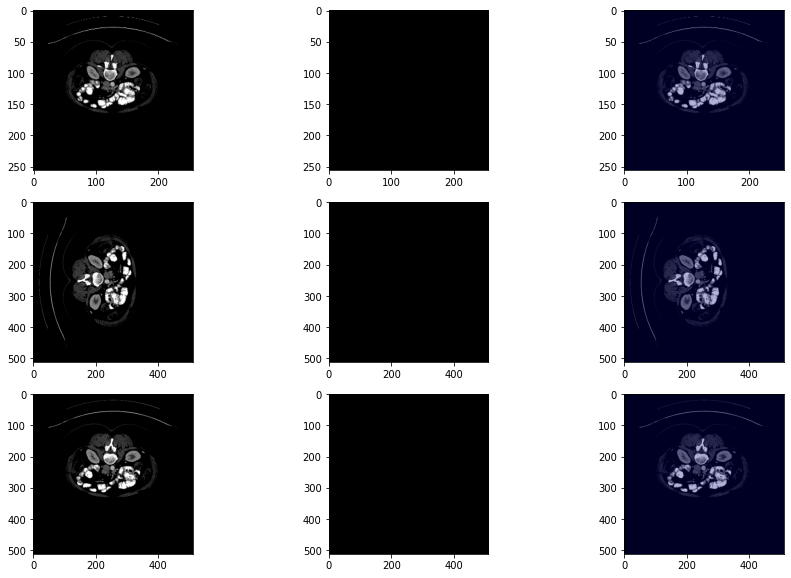

In [21]:
#patient number
p = 'Patient0067'
#n is the slice number in the resized volume
n = 110
#n_o is the slice number in the original volume
n_o = str(int( n * patient_image_cnt_Mask[p] / d3.numpy().size))
im = torch.load('/content/data3D/' + p + '_CT.pt')
m = torch.load('/content/data3D/' + p + '_Mask.pt')
im = im.numpy()
m = m.numpy()
im = np.squeeze(im)[:,:,n]
m = np.squeeze(m)[:,:,n]
im_o = Image.open('/content/data/' + p + '/CT/CT_' + n_o + '.png')
m_o = Image.open('/content/data/' + p + '/Masks/M_' + n_o + '.png')
im_o_t = np.transpose(im_o)
m_o_t = np.transpose(m_o)
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.imshow(im, cmap="gray", interpolation= None)
plt.subplot(3,3,2)
plt.imshow(m, cmap="gray", interpolation= None)
plt.subplot(3,3,3)  
plt.imshow(im, cmap="gray", interpolation= None)
plt.imshow(m, cmap="jet", alpha = 0.3, interpolation= None)
plt.subplot(3,3,4)
plt.imshow(im_o, cmap="gray", interpolation= None)
plt.subplot(3,3,5)
plt.imshow(m_o, cmap="gray", interpolation= None)
plt.subplot(3,3,6)  
plt.imshow(im_o, cmap="gray", interpolation= None)
plt.imshow(m_o, cmap="jet", alpha = 0.3, interpolation= None)
plt.subplot(3,3,7)
plt.imshow(im_o_t, cmap="gray", interpolation= None)
plt.subplot(3,3,8)
plt.imshow(m_o_t, cmap="gray", interpolation= None)
plt.subplot(3,3,9)  
plt.imshow(im_o_t, cmap="gray", interpolation= None)
plt.imshow(m_o_t, cmap="jet", alpha = 0.3, interpolation= None)

###Create slices for 2D based on the resized volumes

In [22]:
 !rm -r data 

In [23]:
if unet_2d:
    !mkdir data/
    slice_cnt = d3.numpy().size
    patient_path_list = {}
    patient_path_list['CT'] = {}
    patient_path_list['Masks'] = {}

    for p in patient_image_cnt_CT.keys():
        path_CT_folder = os.path.join('data', p, 'CT')
        path_mask_folder = os.path.join('data', p, 'Masks')
        os.makedirs(path_CT_folder)
        os.makedirs(path_mask_folder)
        im =  torch.load('/content/data3D/' + p + '_CT.pt')
        m =  torch.load('/content/data3D/' + p + '_Mask.pt')
        im = im.numpy().squeeze(0).squeeze(0)
        m = m.numpy().squeeze(0).squeeze(0)
        for s in range(slice_cnt):
            label = '{:03d}'.format(s)
            ct_path  = os.path.join('/content', 'data', p, 'CT', 'CT_'+ label + '.png' )
            mask_path = os.path.join('/content', 'data', p, 'Masks', "M_" + label + '.png' )    
            cv2.imwrite(ct_path, im[:, :, s])
            cv2.imwrite(mask_path, m[:, :, s])     
        patient_path_list ['CT'][p] = sorted(glob.glob('/content/data/' + p + '/CT/*.png'))        
        patient_path_list ['Masks'][p] = sorted(glob.glob('/content/data/' + p + '/Masks/*.png'))   

###Check the 2D png files

In [24]:
if unet_2d:
    CT_0 = Image.open('/content/data/Patient0017/CT/CT_100.png')
    CT_1 = Image.open('/content/data/Patient0047/CT/CT_100.png')
    CT_2 = Image.open('/content/data/Patient0077/CT/CT_100.png')
    slice_0 = Image.open('/content/data/Patient0017/Masks/M_100.png')
    slice_1 = Image.open('/content/data/Patient0047/Masks/M_100.png')
    slice_2 = Image.open('/content/data/Patient0077/Masks/M_100.png')
    plt.figure(figsize=[15,15])
    plt.subplot(3,3,1)
    plt.imshow(CT_0, cmap="gray", interpolation= None)
    plt.subplot(3,3,2)
    plt.imshow(CT_1, cmap="gray", interpolation= None)
    plt.subplot(3,3,3)
    plt.imshow(CT_2, cmap="gray", interpolation= None)
    plt.subplot(3,3,4 )
    plt.imshow(slice_0, cmap="gray", interpolation= None)
    plt.subplot(3,3,5 )
    plt.imshow(slice_1, cmap="gray", interpolation= None)
    plt.subplot(3,3,6 )
    plt.imshow(slice_2, cmap="gray", interpolation= None)
    plt.subplot(3,3,7)
    plt.imshow(CT_0, cmap="gray", interpolation= None)
    plt.imshow(slice_0, cmap="jet", alpha =0.3, interpolation= None)
    plt.subplot(3,3,8)
    plt.imshow(CT_1, cmap="gray", interpolation= None)
    plt.imshow(slice_1, cmap="jet", alpha =0.3, interpolation= None)
    plt.subplot(3,3,9)
    plt.imshow(CT_2, cmap="gray", interpolation= None)
    plt.imshow(slice_2, cmap="jet", alpha =0.3, interpolation= None)


##3D patch creator

##Partitioning

In [25]:
def partitioning(patients_list, split_ratio):
    part = {'train':[], 'valid':[], 'test':[]}
    train = []
    valid = []
    test = []
    random.shuffle(patients_list)
    l = len(patients_list)
    split_pt = [int(split_ratio[0]*l), int((split_ratio[0]+ split_ratio[1])*l)]
    train =  patients_list [:split_pt[0]]
    valid =  patients_list [split_pt[0]: split_pt[1]]
    test =  patients_list [split_pt[1]:]
    print('train: ', len(train),' ','valid: ', len(valid),' ','test: ', len(test),' ','total: ',len(train)+len(valid)+len(test))
    part['train'] = train
    part['valid'] = valid
    part['test'] = test
    return part

part = partitioning([*patient_image_cnt_CT.keys()], split_ratio = [0.7,0.1,0.2])

train:  56   valid:  7   test:  17   total:  80


###2D partitions

In [26]:
if unet_2d:
    partition_train = {}
    partition_train ['CT'] = []
    partition_train ['Masks'] = []
    for p in part['train']:
        partition_train ['CT'].extend(patient_path_list ['CT'][p] )
        partition_train ['Masks'].extend(patient_path_list ['Masks'][p] )
    partition_valid = {}
    partition_valid ['CT'] = []
    partition_valid ['Masks'] = []
    for p in part['valid']:
        partition_valid ['CT'].extend(patient_path_list ['CT'][p] )
        partition_valid ['Masks'].extend(patient_path_list ['Masks'][p] )
        
    partition_test= {}
    for p in part['test']:
        partition_test [p] = {}  
        partition_test[p] ['CT'] = []
        partition_test[p] ['Masks'] = []
        partition_test[p] ['CT'].extend(patient_path_list ['CT'][p])
        partition_test[p] ['Masks'].extend(patient_path_list ['Masks'][p])

###3D partitions

In [27]:
if unet_2d == False:
    CT_patches = {}
    mask_patches ={}
    for p in ['train', 'valid', 'test']:
        CT_patches[p], mask_patches[p] = patch_creator(part[p], kw, kh, kc, dw, dh, dc)

## Constructing the dataset and the dataloader

In [28]:
# Construct the dataset
if unet_2d:
    dataset_train = Pancreas_2D_dataset (partition_train, augment= True)
    dataset_valid = Pancreas_2D_dataset (partition_valid, augment= False)        
    dataset_test ={}
    for p in partition_test:
      dataset_test[p] = Pancreas_2D_dataset (partition_test[p], augment = False)
else:
    dataset_train = Pancreas_3D_dataset (CT_patches['train'], mask_patches['train'], augment= True)
    dataset_valid = Pancreas_3D_dataset (CT_patches['valid'], mask_patches['valid'], augment= False)
    #dataset_test = Pancreas_3D_dataset (CT_patches['test'], mask_patches['test'], augment= False)

In [29]:
# Generators (data loaders)
loaders={}
loaders['train'] = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, 
                                                num_workers=num_workers)
loaders['valid'] = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, 
                                                num_workers=num_workers)

##Get sample batch from loader

In [30]:
batch = iter(loaders['valid'])

In [31]:
image, mask = next(batch)

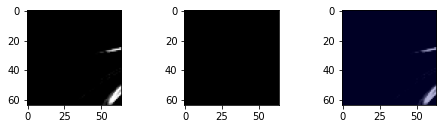

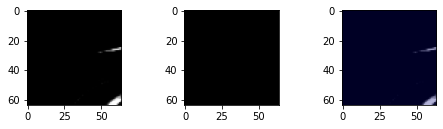

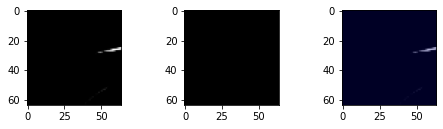

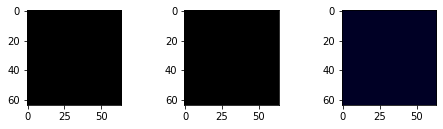

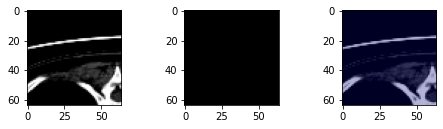

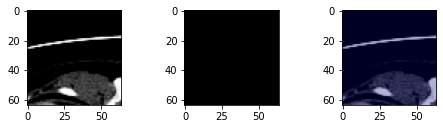

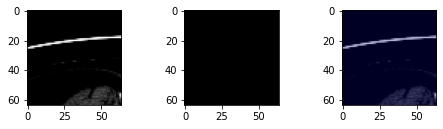

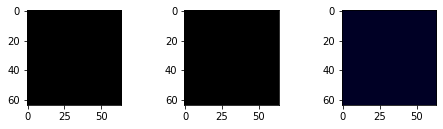

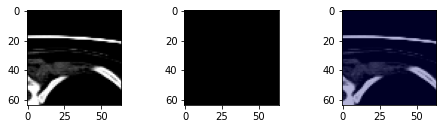

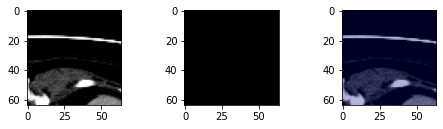

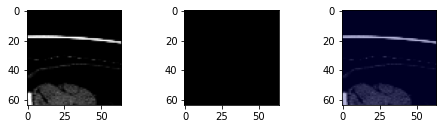

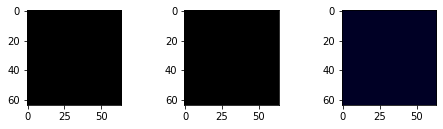

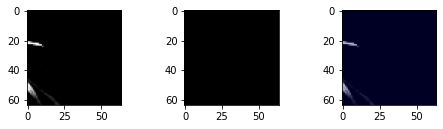

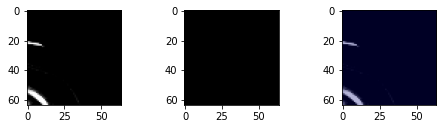

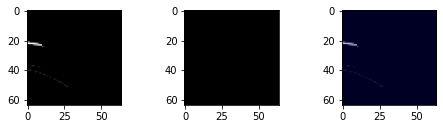

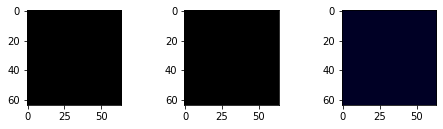

In [32]:
if unet_2d:
    for im, m in zip(image, mask):
        im = im.numpy()
        m = m.numpy()
        im = np.squeeze(im)
        m = np.squeeze(m)
        #print(m.dtype, np.unique(m))
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(im, cmap="gray", interpolation= None)
        plt.subplot(1,3,2)
        plt.imshow(m, cmap="gray", interpolation= None)
        plt.subplot(1,3,3)  
        plt.imshow(im, cmap="gray", interpolation= None)
        plt.imshow(m, cmap="jet", alpha = 0.3, interpolation= None)
else:
    for im, m in zip(image, mask):
        im = im.permute(0,3,2,1)
        m = m.permute(0,3,2,1)
        im = im.numpy()
        m = m.numpy()
        #print(im.shape, m.shape)
        im = np.squeeze(im)
        m = np.squeeze(m)
        plt.figure(figsize=(8,8))
        plt.subplot(4,3,1)
        plt.imshow(im[:,:,20], cmap="gray", interpolation= None)
        plt.subplot(4,3,2)
        plt.imshow(m[:,:,20], cmap="gray", interpolation= None)
        plt.subplot(4,3,3)
        plt.imshow(im[:,:,20], cmap="gray", interpolation= None)
        plt.imshow(m[:,:,20], cmap="jet", alpha = 0.3, interpolation= None)
        

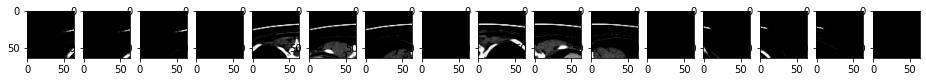

In [33]:
plt.figure(figsize=(16,8))
if unet_2d==False:
    for i, (im, m) in enumerate(zip(image, mask)):
        im = im.permute(0,3,2,1)
        #m = m.permute(0,3,2,1)
        im = im.numpy()
        #m = m.numpy()
        #print(im.shape, m.shape)
        im = np.squeeze(im)
        #m = np.squeeze(m)
        plt.subplot(1,batch_size, i+1)
        plt.imshow(im[:,:,20], cmap="gray", interpolation= None)

##Model Architecture

In [34]:
# instantiate the unet
if unet_2d:
    model = UNet_2D(1,1,32,0.2)
else:
    model = UNet_3D(1,1,32,0.2)

In [35]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

In [36]:
if unet_2d:
  summary(model, (1,256, 256), batch_size = batch_size)
else:
  summary(model, (1, 32, 64, 64), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [16, 32, 32, 64, 64]             864
       BatchNorm3d-2       [16, 32, 32, 64, 64]              64
              ReLU-3       [16, 32, 32, 64, 64]               0
            Conv3d-4       [16, 32, 32, 64, 64]          27,648
       BatchNorm3d-5       [16, 32, 32, 64, 64]              64
              ReLU-6       [16, 32, 32, 64, 64]               0
         MaxPool3d-7       [16, 32, 16, 32, 32]               0
           Dropout-8       [16, 32, 16, 32, 32]               0
            Conv3d-9       [16, 64, 16, 32, 32]          55,296
      BatchNorm3d-10       [16, 64, 16, 32, 32]             128
             ReLU-11       [16, 64, 16, 32, 32]               0
           Conv3d-12       [16, 64, 16, 32, 32]         110,592
      BatchNorm3d-13       [16, 64, 16, 32, 32]             128
             ReLU-14       [16, 64, 16,

##Loss, optimizer, and learning rate scheduler

In [37]:
criterion = TverskyLoss(0.00000001,0.3,.7)
#lr_find = False
# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr = .003)
if lr_find == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.037, steps_per_epoch=len(loaders['train']), epochs=n_epochs)        #(optimizer, max_lr=0.01, total_steps=4000)


In [38]:
if lr_find:

    #https://github.com/davidtvs/pytorch-lr-finder
    desired_batch_size, real_batch_size = batch_size, batch_size
    accumulation_steps = desired_batch_size // real_batch_size


    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loaders['train'], end_lr=1, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state

##Training

In [39]:
if inference_only == False:
  # train the model
  if unet_2d:
      model = train_2D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, performance_metrics, 'model.pt')
  else:
      model = train_3D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, performance_metrics, 'model.pt')
else:
  # load the model that got the best validation accuracy
  model.load_state_dict(torch.load('model.pt'))

  0%|          | 0/3 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 224...
51 / 224...
101 / 224...
151 / 224...
201 / 224...
=== Validation ===
1 / 28...
Epoch: 1 	Training Loss: 0.9907 	Validation Loss: 0.9969
Specificity: 0.998332 	Sensitivity: 0.000192 	F2_score: 0.250221 	DSC: 0.250294
Validation DSC increased.  Saving model ...


 33%|███▎      | 1/3 [06:18<12:37, 378.78s/it]

=== Epoch #2 ===
=== Training ===
1 / 224...
51 / 224...
101 / 224...
151 / 224...
201 / 224...
=== Validation ===
1 / 28...


 67%|██████▋   | 2/3 [12:43<06:21, 381.52s/it]

Epoch: 2 	Training Loss: 0.9785 	Validation Loss: 0.9854
Specificity: 0.998881 	Sensitivity: 0.010850 	F2_score: 0.227558 	DSC: 0.234256


In [44]:
#%debug

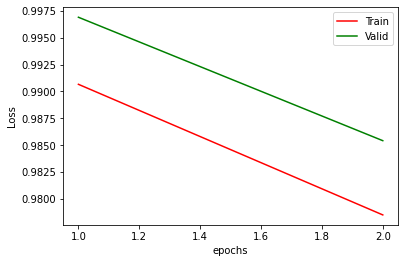

In [41]:
loss=pd.read_csv('performance_metrics.csv',header=0,index_col=False)


plt.plot(loss['epoch'],loss['Training Loss'],'r',loss['epoch'],loss['Validation Loss'],'g')

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(labels=['Train','Valid'])
plt.show()

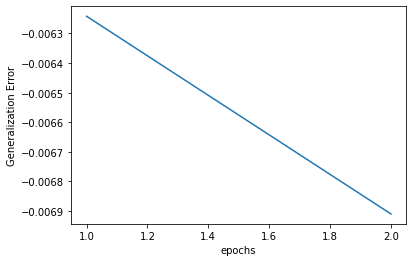

In [42]:
plt.plot(loss['epoch'],loss['Training Loss']-loss['Validation Loss'])
plt.xlabel('epochs')
plt.ylabel('Generalization Error')
plt.show()

##Test

In [43]:
!pip install pipreqs
!pipreqs 

INFO: Successfully saved requirements file in /content/requirements.txt


In [ ]:
#model.load_state_dict(torch.load('/content/model_3D_32_ReLU.pt'))

In [ ]:
if unet_2d:
    test_metrics =[]
    model.eval()
    for p in partition_test:
      loaders['test'] = torch.utils.data.DataLoader(dataset_test[p], batch_size=batch_size, shuffle=False, 
                                                  num_workers=num_workers)
      
      specificity_val = 0
      sensitivity_val = 0
      precision_val = 0
      F1_score_val = 0
      F2_score_val = 0
      DSC_val = 0
      test_cnt = 0

      
      for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        output = output.cpu().detach().numpy()
        output_b = (output>0.5)*1
        output_b = np.squeeze(output_b)
        batch_l = output_b.size
        test_cnt += batch_l
        t1 = transforms.ToTensor()
        output_b = t1(output_b)
        output_b = output_b.cuda()
        m = performance_metrics(smooth = 1e-6)
        specificity, sensitivity, precision, F1_score, F2_score, DSC =  m(target, output_b)    
        specificity_val += specificity * batch_l
        sensitivity_val += sensitivity * batch_l
        precision_val += precision * batch_l
        F1_score_val += F1_score * batch_l
        F2_score_val += F2_score * batch_l 
        DSC_val += DSC * batch_l 
        
      
      specificity_val, sensitivity_val, precision_val, F1_score_val, F2_score_val, DSC_val = specificity_val.cpu().numpy()/test_cnt, sensitivity_val.cpu().numpy()/test_cnt, precision_val.cpu().numpy()/test_cnt, F1_score_val.cpu().numpy()/test_cnt, F2_score_val.cpu().numpy()/test_cnt, DSC_val.cpu().numpy()/test_cnt
      print('Specificity: {:.6f} \tSensitivity: {:.6f} \tF2_score: {:.6f} \tDSC: {:.6f}'.format(
          specificity_val,
          sensitivity_val, 
          F2_score_val, 
          DSC_val
      ))
      
      #test_metrics.append((p, specificity_val.cpu().numpy().astype(np.float), sensitivity_val.cpu().numpy(), precision_val.cpu().numpy(), F1_score_val.cpu().numpy(), F2_score_val.cpu().numpy(), DSC_val.cpu().numpy() ))
      test_metrics.append((p, specificity_val, sensitivity_val, precision_val, F1_score_val, F2_score_val, DSC_val ))
    #save the test metrics
    df=pd.DataFrame.from_records(test_metrics, columns=['Patient', 'specificity', 'sensitivity', 'precision', 'F1_score', 'F2_score', 'DSC' ])
    df.to_csv('test_metrics.csv', index=False)       



In [ ]:
if unet_2d==False:
    #batch_size = 16
    dataset_test =[]
    test_metrics =[]
    model.eval()
    
    for p in part['test']:
        CT_patches = {}
        mask_patches ={}
        CT_patches[p], mask_patches[p] = patch_creator([p]) 
        dataset_test= Pancreas_3D_dataset (CT_patches[p], mask_patches[p], augment= False)
        loaders['test'] = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, 
                                                    num_workers=num_workers)
        
        specificity_val = 0
        sensitivity_val = 0
        precision_val = 0
        F1_score_val = 0
        F2_score_val = 0
        DSC_val = 0
        test_cnt = 0

        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass
            output = model(data)

            output = output.cpu().detach().numpy()
            output_b = (output>0.5)*1
            output_b = np.squeeze(output_b)
            #print(output_b.dtype, output_b.shape, output_b.size)
            batch_l = output_b.size
            test_cnt += batch_l
            output_b = torch.as_tensor(output_b)
            #t1= transforms.ToTensor()
            #output_b = t1(output_b)
            output_b = output_b.cuda()
            m = performance_metrics(smooth = 1e-6)
            specificity, sensitivity, precision, F1_score, F2_score, DSC =  m(target, output_b)    
            specificity_val += specificity * batch_l
            sensitivity_val += sensitivity * batch_l
            precision_val += precision * batch_l
            F1_score_val += F1_score * batch_l
            F2_score_val += F2_score * batch_l
            DSC_val += DSC * batch_l 
            
        specificity_val, sensitivity_val, precision_val, F1_score_val, F2_score_val, DSC_val = specificity_val.cpu().numpy()/test_cnt, sensitivity_val.cpu().numpy()/test_cnt, precision_val.cpu().numpy()/test_cnt, F1_score_val.cpu().numpy()/test_cnt, F2_score_val.cpu().numpy()/test_cnt, DSC_val.cpu().numpy()/test_cnt
        test_metrics.append((p,specificity_val, sensitivity_val, precision_val, F1_score_val, F2_score_val, DSC_val ))
        #save the test metrics
    df=pd.DataFrame.from_records(test_metrics, columns=['Patient', 'specificity', 'sensitivity', 'precision', 'F1_score', 'F2_score', 'DSC' ])
    df.to_csv('test_metrics.csv', index=False)       



In [ ]:
df

,Patient,specificity,sensitivity,precision,F1_score,F2_score,DSC
0,Patient0030,0.999233,0.221667,0.059220,0.843469,0.893138,0.843469
1,Patient0004,0.998951,0.132466,0.009462,0.767662,0.786796,0.767662
2,Patient0082,0.998958,0.123446,0.035180,0.804756,0.832199,0.804756
3,Patient0054,0.999746,0.316078,0.367941,0.825690,0.817100,0.825690
4,Patient0033,0.999102,0.223083,0.174596,0.672750,0.688109,0.672750
5,Patient0056,0.999054,0.480168,0.186198,0.766676,0.862240,0.766676
6,Patient0022,0.999147,0.353964,0.251505,0.779475,0.814795,0.779474
7,Patient0066,0.998649,0.261952,0.083373,0.623441,0.673574,0.623438
8,Patient0006,0.999742,0.378038,0.349347,0.859769,0.869595,0.859769
9,Patient0063,0.999099,0.162793,0.082741,0.859717,0.636400,0.609717


In [ ]:
df.describe()

,specificity,sensitivity,precision,F1_score,F2_score,DSC
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.999103,0.322423,0.181420,0.770694,0.797708,0.755988
std,0.000351,0.114374,0.116684,0.080608,0.081780,0.085978
min,0.998649,0.123446,0.009462,0.582441,0.636400,0.582441
25%,0.998870,0.223083,0.082741,0.749578,0.786796,0.744624
50%,0.999054,0.353964,0.177680,0.779475,0.819384,0.767662
75%,0.999166,0.406174,0.251505,0.825690,0.843797,0.804756
max,0.999767,0.480168,0.367941,0.868302,0.893138,0.868302


In [ ]:
if unet_2d:
    patient = part['test'][13]
    print(patient)
    p = partition_test[patient]
    loaders['test'] = torch.utils.data.DataLoader(dataset_test[patient], batch_size=batch_size, shuffle=False, 
                                                    num_workers=num_workers)
    for batch_idx, (data, target) in enumerate(loaders['test']):
      # move to GPU
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
      output = model(data)
      output = output.cpu().detach().numpy()
      output_b = (output>0.5)*1
      output_b = np.squeeze(output_b)

      for gt, pred in zip(target.cpu().numpy(), output_b):
        gt = np.squeeze(gt)
        pred = np.squeeze(pred)
        plt.figure(figsize=(3,6))
        plt.subplot(1,2,1)
        plt.imshow(gt, cmap="gray", interpolation= None)
        plt.subplot(1,2,2)
        plt.imshow(pred, cmap="gray", interpolation= None)
    

In [ ]:
if unet_2d==False:
    model.eval()
    p ='Patient0057'
    CT_patches = []
    mask_patches =[]
    CT_patches, mask_patches = patch_creator([p]) 
    dataset_test= Pancreas_3D_dataset (CT_patches, mask_patches, augment= False)
    loaders['test'] = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, 
                                                num_workers=num_workers)
    predict_subvol= {}
    CT_subvol = {}
    mask_subvol ={}
    
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        output = output.cpu().detach().numpy()
        output_b = (output>0.5)*1
        predict_subvol[batch_idx] = np.squeeze(output_b)
        CT_subvol[batch_idx] = np.squeeze(data.cpu().detach().numpy())
        mask_subvol[batch_idx] = np.squeeze(target.cpu().detach().numpy())
        

In [ ]:
i

33

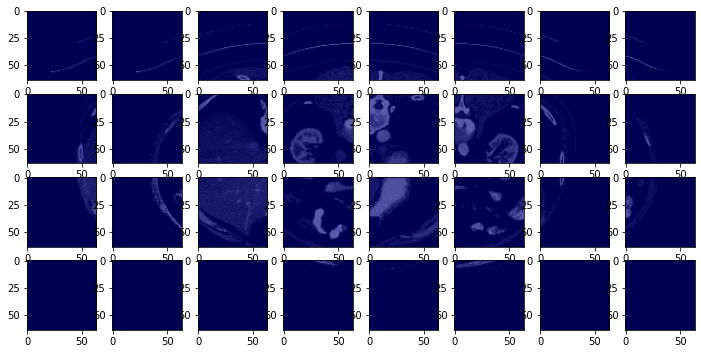

In [ ]:
if unet_2d==False:
    plt.close()
    plt.figure(figsize=(12,12))
    k=31
    i=1
    image = {}
    mask = {}
    prediction = {}
    for q in range(4):
        for j, (im, m, pred)  in enumerate(zip(CT_subvol[q], mask_subvol[q],predict_subvol[q])):
            #print(im.shape, m.shape, pred.shape)
            if j%2 == 0:
                im = np.squeeze(im).transpose(0,2,1)
                m = np.squeeze(m).transpose(0,2,1)
                pred= pred.transpose(0,2,1)
                plt.subplot(8,8, i)
                plt.imshow(im[k,:,:], cmap="gray", interpolation= None)
                plt.imshow(pred[k, :,:], cmap="jet", alpha = 0.5, interpolation= None)  
                plt.imshow(m[k, :,:], cmap="jet", alpha = 0.3, interpolation= None)  
                image[i-1] = im[k,:,:]
                mask[i-1] = m[k,:,:]
                prediction[i-1] = pred[k,:,:]

                i+=1
                

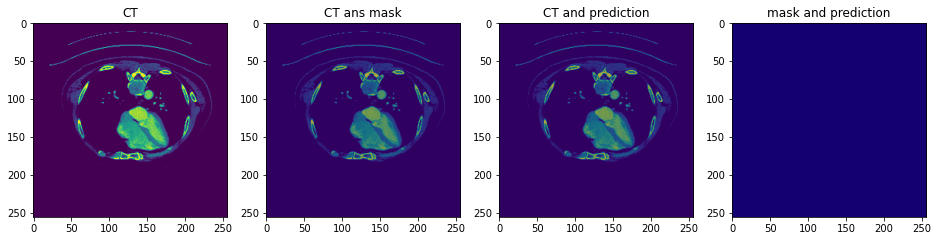

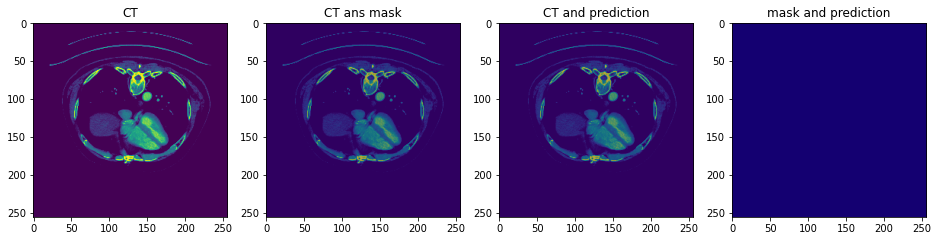

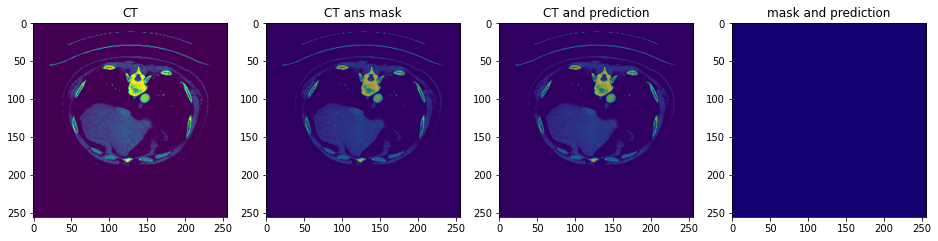

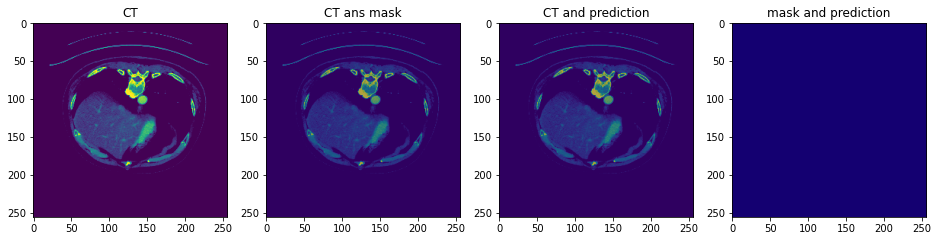

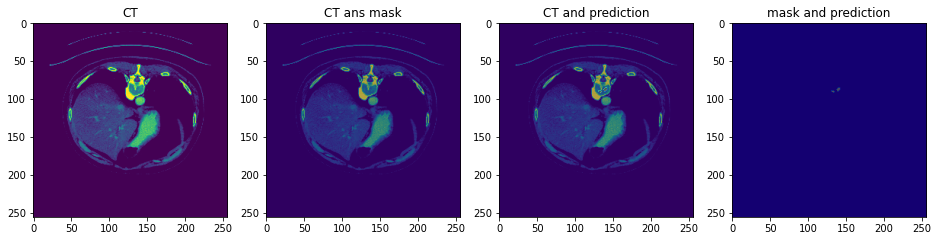

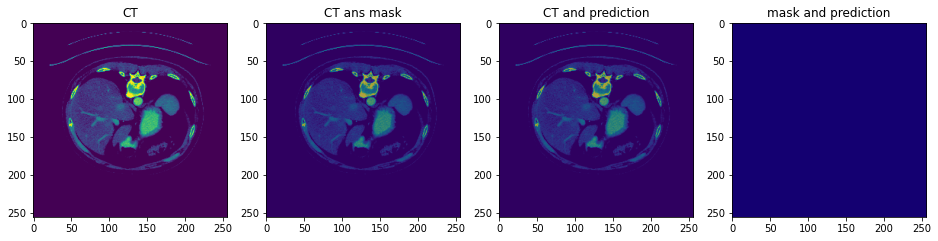

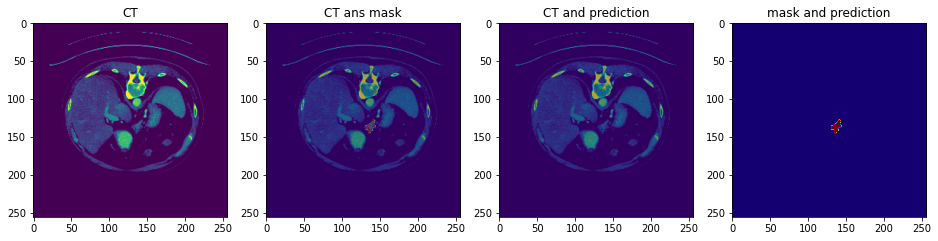

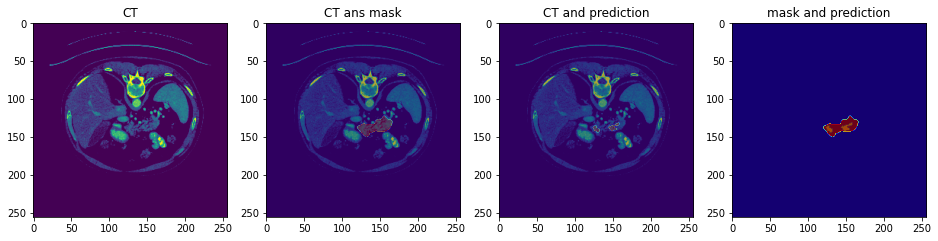

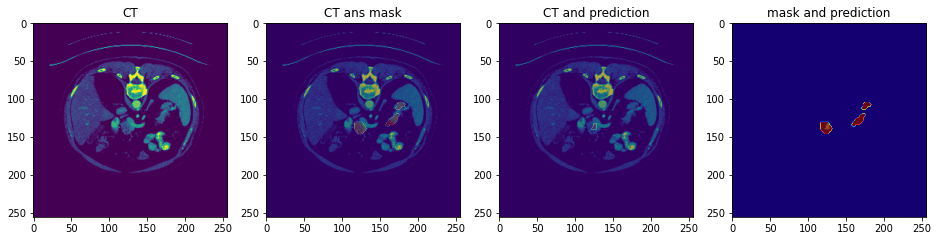

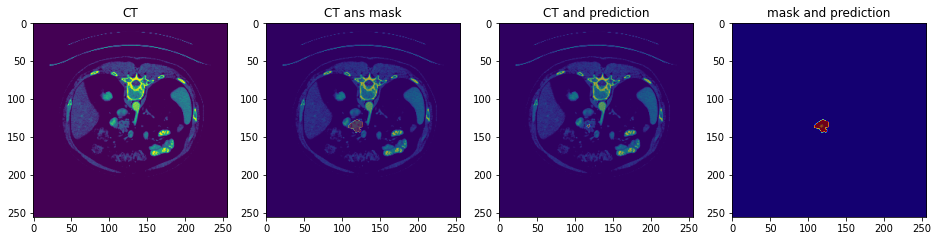

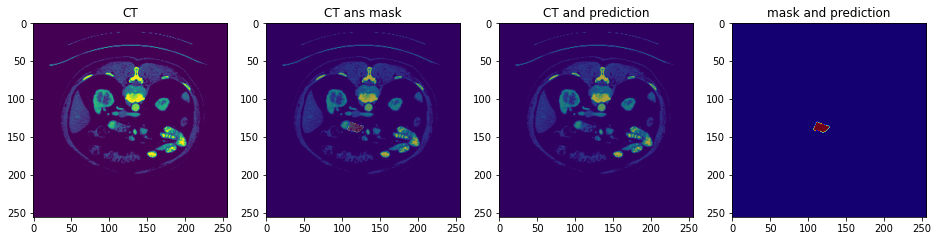

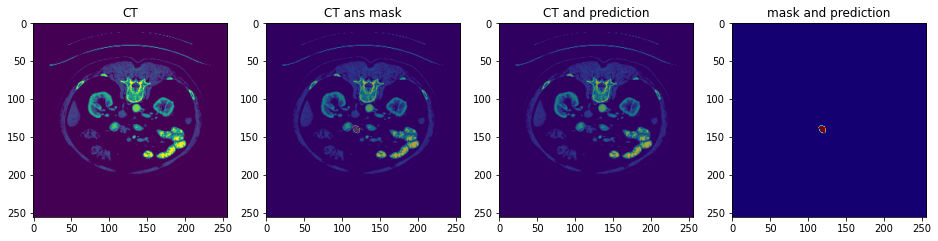

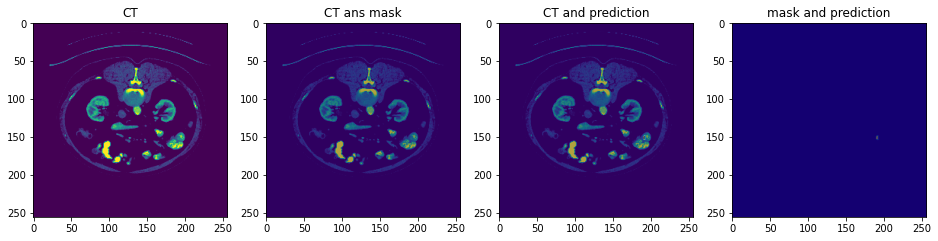

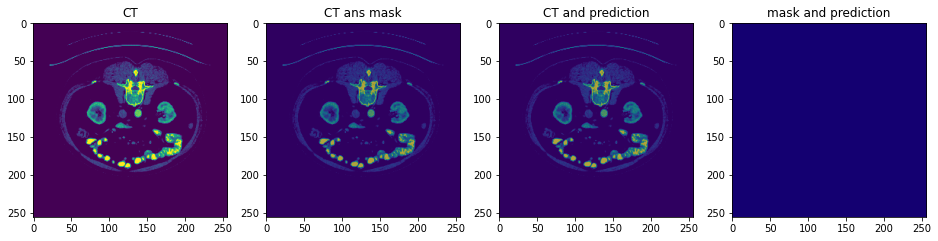

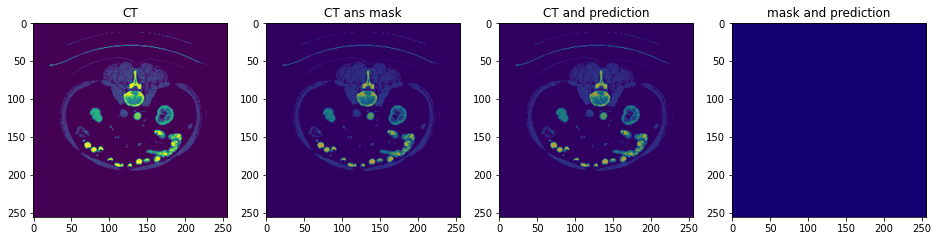

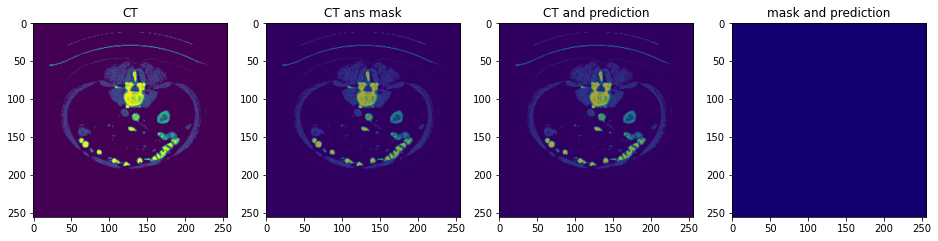

In [ ]:
if unet_2d==False:
    def volume(num_batch_width, num_batches, r, CT_subvol, mask_subvol,predict_subvol):
        image_vol = []
        mask_vol =[]
        prediction_vol = [] 
        for k in range(kc):        
            idx=1
            image = {}
            mask = {}
            prediction = {}
            for q in range(num_batches):
                for j, (im, m, pred)  in enumerate(zip(CT_subvol[q], mask_subvol[q],predict_subvol[q])):
                    if j%num_batch_depth == r:
                        im = np.squeeze(im).transpose(0,2,1)
                        m = np.squeeze(m).transpose(0,2,1)
                        pred= pred.transpose(0,2,1)
                        image[idx-1] = im[k,:,:]
                        mask[idx-1] = m[k,:,:]
                        prediction[idx-1] = pred[k,:,:]
                        idx+=1
            image_row ={}
            mask_row ={}
            prediction_row ={}
            for i in range(num_batch_width):
                image_row[i] = np.hstack((image[num_batch_width*i + 0],image[num_batch_width*i + 1],image[num_batch_width*i + 2],image[num_batch_width*i + 3]))
                mask_row[i] = np.hstack((mask[num_batch_width*i + 0],mask[num_batch_width*i + 1],mask[num_batch_width*i + 2],mask[num_batch_width*i + 3]))
                prediction_row[i] = np.hstack((prediction[num_batch_width*i + 0], prediction[num_batch_width*i + 1], prediction[num_batch_width*i + 2], prediction[num_batch_width*i + 3]))
            image_vol.append(np.vstack((image_row[0], image_row[1], image_row[2], image_row[3])))
            mask_vol.append(np.vstack((mask_row[0], mask_row[1], mask_row[2], mask_row[3])))
            prediction_vol.append(np.vstack((prediction_row[0], prediction_row[1], prediction_row[2], prediction_row[3])))
        return image_vol, mask_vol, prediction_vol

    num_batches = 256*256*128 // (kc*kh*kw*batch_size)
    num_batch_depth = 128//kc
    num_batch_width = 256//kw
    image_volume = []
    mask_volume =[]
    prediction_volume =[]
    for r in range(num_batch_depth):
        image_vol, mask_vol, prediction_vol = volume(num_batch_width, num_batches, r, CT_subvol, mask_subvol,predict_subvol)
        image_volume.extend(image_vol)
        mask_volume.extend(mask_vol)
        prediction_volume.extend(prediction_vol)
    
    nifti_image_np=np.array(image_volume)
    nifti_image = nib.Nifti1Image(nifti_image_np, np.eye(4))  # Save axis for data (just identity)
    nifti_mask_np=np.array(mask_volume)
    nifti_mask = nib.Nifti1Image(nifti_mask_np, np.eye(4))  # Save axis for data (just identity)
    nifti_prediction_np=np.array(prediction_volume).astype('int32')
    nifti_prediction = nib.Nifti1Image(nifti_prediction_np, np.eye(4))  # Save axis for data (just identity)

    nifti_image.header.get_xyzt_units()
    nifti_image.to_filename('image.nii.gz')  # Save as NiBabel file
    nifti_mask.header.get_xyzt_units()
    nifti_mask.to_filename('mask.nii.gz')  # Save as NiBabel file
    nifti_prediction.header.get_xyzt_units()
    nifti_prediction.to_filename('prediction.nii.gz')  # Save as NiBabel file
    for k in range(0,128,8):
        plt.figure(figsize=(16,16))
        plt.subplot(1,4,1)
        plt.imshow(nifti_image_np[k,:,:])
        plt.title('CT')
        plt.subplot(1,4,2)
        plt.imshow(nifti_image_np[k,:,:])
        plt.imshow(nifti_mask_np[k,:,:], cmap="jet", alpha = 0.3, interpolation= None)  
        plt.title('CT ans mask')
        plt.subplot(1,4,3)
        plt.imshow(nifti_image_np[k,:,:])
        plt.imshow(nifti_prediction_np[k,:,:], cmap="jet", alpha = 0.3, interpolation= None)  
        plt.title('CT and prediction')
        plt.subplot(1,4,4)
        plt.imshow(nifti_prediction_np[k,:,:])
        plt.imshow(nifti_mask_np[k,:,:], cmap="jet", alpha = 0.7, interpolation= None)
        plt.title('mask and prediction')